# perform inference using oscillations of random amplitude and frequency


In [2]:
import numpy as np
import os, sys
import json

project_root = os.path.abspath("")  # alternative
if project_root[-12:] == 'LyoSavin2023':
    base_dir = project_root
else:
    base_dir = os.path.dirname(project_root)
sys.path.append(os.path.join(base_dir, 'core'))
sys.path.append(os.path.join(base_dir, 'core/utils'))

import torch
import torch.optim as optim
import time
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
import zarr

from utils import remove_all_ticks_and_labels

## first vary the frequency of the oscillation

we want to maintain the sinusoidal shape, only varying the frequency

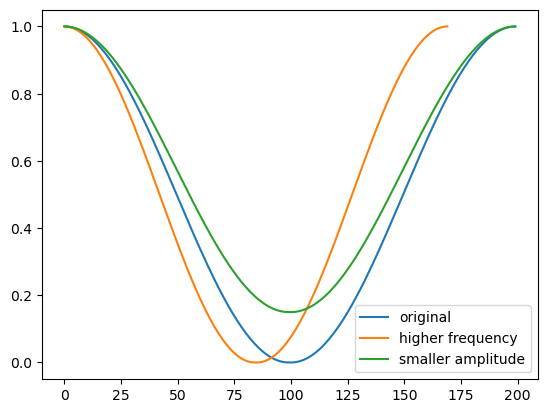

In [62]:
# show the different beta schedules
from utils import make_beta_schedule, convert_beta_l_to_beta_t, convert_beta_t_to_beta_l

n_timesteps = 100

betas = make_beta_schedule('sine', n_timesteps=n_timesteps)

def make_beta_t_schedule(n_timesteps=100, n_periods=1):
    betas = make_beta_schedule(schedule='sine', n_timesteps=n_timesteps)
    betas_one_period = torch.cat([betas, reversed(betas)])
    beta_t_one_period = convert_beta_l_to_beta_t(betas_one_period, betas)
    beta_t = torch.cat([beta_t_one_period for _ in range(n_periods)])
    return beta_t

# original beta schedule
b = make_beta_t_schedule(n_timesteps=100, n_periods=1)

# higher frequency beta schedule
b_higher_freq = make_beta_t_schedule(n_timesteps=85, n_periods=1)

# smaller amplitude beta schedule
def make_beta_schedule_different_amplitude(amplitude, betas):
    b_l_different_amp_min = convert_beta_t_to_beta_l(1-amplitude, betas)
    betas_different_amp = make_beta_schedule('sine', n_timesteps, end=b_l_different_amp_min)
    b_different_amp = convert_beta_l_to_beta_t(torch.cat([betas_different_amp, reversed(betas_different_amp)]), betas)
    return b_different_amp

b_smaller_amp = make_beta_schedule_different_amplitude(.85, betas)

# b_l_smaller_amp_max = convert_beta_t_to_beta_l(1.2, betas)
# print(b_l_smaller_amp_max)
# betas_smaller_amp = make_beta_schedule('sine', n_timesteps, start=b_l_smaller_amp_max)
# b_smaller_amp = convert_beta_l_to_beta_t(torch.cat([betas_smaller_amp, reversed(betas_smaller_amp)]), betas)

fig, ax = plt.subplots(1, 1)
ax.plot(b, label='original')
ax.plot(b_higher_freq, label='higher frequency')
ax.plot(b_smaller_amp, label='smaller amplitude')
ax.legend()

torch.Size([2034])


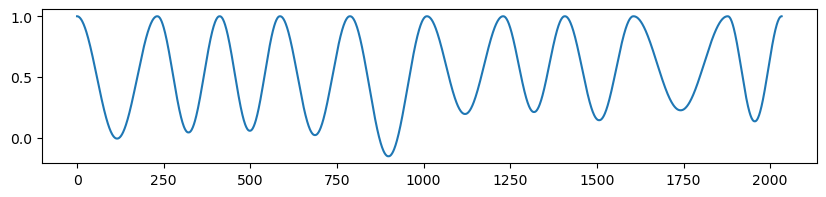

In [66]:
# now make the period and amplitude random variables
n_periods = 10
periods = torch.normal(100, 15, size=(n_periods,)).to(torch.int64)
amplitudes = torch.normal(1, .15, size=(n_periods,))

def make_random_beta_oscillations(betas, n_timesteps=100, n_periods=1, periods=[100], amplitudes=[1]):
    beta_multiple_periods = []
    for i in range(n_periods):
        period = periods[i]
        amplitude = amplitudes[i]
        b_l_different_amp_min = convert_beta_t_to_beta_l(1-amplitude, betas)
        beta_ls = make_beta_schedule('sine', period, end=b_l_different_amp_min)
        beta_ts = convert_beta_l_to_beta_t(torch.cat([beta_ls, reversed(beta_ls)]), betas)
        beta_multiple_periods.append(beta_ts)
    beta_multiple_periods = torch.cat(beta_multiple_periods)
    return beta_multiple_periods

betas_multiple_periods = make_random_beta_oscillations(betas, n_periods=10, periods=periods, amplitudes=amplitudes)
print(betas_multiple_periods.shape)

fig, ax = plt.subplots(1, 1, figsize=(10, 2))
ax.plot(betas_multiple_periods)

In [ ]:
# now draw samples from the manifold using the random beta oscillations
